#LIME

This Jupyter Notebook imports various libraries and modules including PyTorch, Captum, NumPy, PIL (Python Imaging Library), and Matplotlib. It then loads a pre-trained ResNet-18 model from the torchvision.models library and sets it to evaluation mode. An image is loaded and resized to the required input size for the model. A mask is also created manually to highlight a specific part of the image. The image and mask are preprocessed and converted to tensors. The model is used to make a prediction on the image, and the output probabilities are calculated using softmax. The LIME (Local Interpretable Model-agnostic Explanations) explainer is then set up with a similarity function and a linear regression model. Finally, the attributions are generated using LIME with the image tensor, target label, feature mask, and other parameters.

This Jupyter notebook is based on:

* https://captum.ai/tutorials/Image_and_Text_Classification_LIME
* https://captum.ai/docs/attribution_algorithms#lime
* https://arxiv.org/abs/1602.04938

#### Installing Captum Library

The following line installs version 0.6.0 of the Captum library.

This version is used because it is compatible with the other libraries used in this notebook.

In [1]:
!pip install matplotlib==3.6 captum==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.1 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


#### Configuring Matplotlib for Displaying Images

The following line configures Matplotlib to display images without padding.

This configuration is necessary because Matplotlib adds padding around images by default, which can affect the layout of the notebook. Setting the `bbox_inches` parameter to `None` removes the padding and ensures that images are displayed at their original size without any cropping or scaling.

In [1]:
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Using LIME
An image is loaded and a mask is defined manually. The image and mask are preprocessed using transforms and then fed into the ResNet model to generate predictions. The LIME explainer is set up to generate attributions using the LIME method with a linear regression model and a specified similarity function. The attributions are then computed using the attribute method of the LIME explainer.

In [1]:
import torch
import torch.nn.functional as F
from captum.attr import visualization as viz
from captum.attr import Lime, LimeBase
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso
import os
import json
from torchvision.models import resnet18
import torchvision.transforms as T
from captum.attr._core.lime import get_exp_kernel_similarity_function
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import torchvision.transforms as transforms
from PIL import ImageDraw

# Load the ResNet model
resnet = resnet18(pretrained=True)
resnet = resnet.eval()

img = Image.open('/content/drive/MyDrive/Colab Notebooks/images/red_traffic_light_0.jpg')

# Define the mask manually
mask = Image.new('L', img.size, 0)
draw = ImageDraw.Draw(mask)
draw.rectangle([(300, 380), (500, 1000)], fill=255)
# Convert the mask to an RGB image with three identical channels
mask_rgb = Image.merge("RGB", [mask, mask, mask])


# Define the input size of the model

# Preprocess the image and mask
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img_tensor = preprocess(img)
img_tensor = img_tensor.unsqueeze(0)

mask_tensor = preprocess(mask_rgb)
mask_tensor = mask_tensor.unsqueeze(0)
mask_tensor = (mask_tensor > 0.5).float()

# Make predictions with the model
outputs = resnet(img_tensor)
output_probs = F.softmax(outputs, dim=1).squeeze(0)

# Set up the LIME explainer
exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=100)
lr_lime = Lime(
    resnet,
    interpretable_model=SkLearnLinearRegression(),
    similarity_func=exp_eucl_distance
)

label_idx = output_probs.argmax().unsqueeze(0)

# Generate attributions with LIME
attrs = lr_lime.attribute(
    img_tensor,
    target=label_idx.long(),
    feature_mask=mask_tensor.long(),
    n_samples=8,
    perturbations_per_eval=16,
    show_progress=True
).squeeze(0)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Lime attribution:   0%|          | 0/1 [00:00<?, ?it/s]

#### Visualization
The first block of code displays the input image and the traffic light mask after resizing, and the second block displays the attribution heatmap using Captum's visualization tools. The heatmap is created based on the LIME algorithm and shows the attribution scores of each pixel in the input image towards the model's prediction. The range of attribution scores is printed after displaying the heatmap.

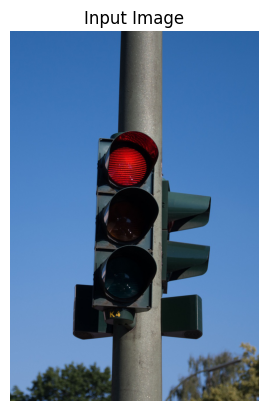

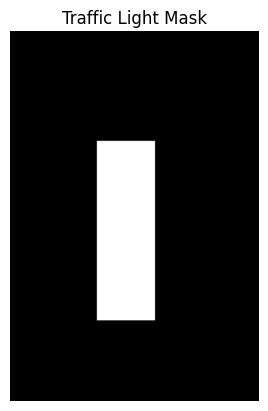

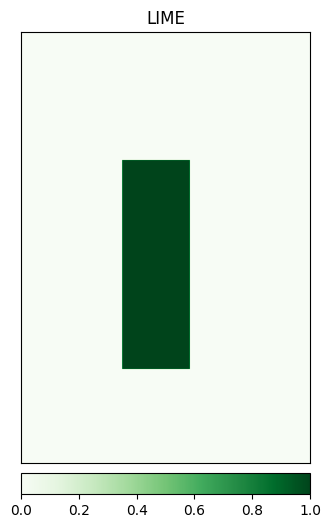

Attribution range: 0.0 to 2.1016077995300293


In [3]:
plt.imshow(img)
plt.axis('off')
plt.title('Input Image')
plt.show()
plt.axis('off')
plt.imshow(mask_rgb)
plt.title('Traffic Light Mask')
plt.show()
# Display the heatmap

_ = viz.visualize_image_attr(
        attrs.permute(1, 2, 0).numpy(),  # adjust shape to height, width, channels
        method='heat_map',
        sign='positive',
        alpha_overlay=0.4,
        show_colorbar=True,
        title='LIME')
print('Attribution range:', attrs.min().item(), 'to', attrs.max().item())